# 3D Point Cloud Classification with Simple PointNet

Normalization

In [1]:
def normalize_point_cloud(points):
    """
    Normalize a point cloud to be centered at the origin and fit within a unit sphere.

    :param points: (N, 3) numpy array representing the point cloud.
    :return: Normalized point cloud.
    """
    # 1. Centering: Shift the centroid to the origin
    centroid = np.mean(points, axis=0)
    points -= centroid

    # 2. Scaling: Normalize by the max distance to the origin
    max_distance = np.max(np.linalg.norm(points, axis=1))
    points /= max_distance

    return points, centroid, max_distance

Denormalization

In [2]:
def denormalize_point_cloud(points, centroid, max_distance):
    """
    Denormalize a point cloud to its original coordinates.

    :param points: Normalized point cloud.
    :param centroid: Centroid of the original point cloud.
    :param max_distance: Maximum distance from the origin.
    :return: Denormalized point cloud.
    """
    # 1. Reverse scaling
    points *= max_distance

    # 2. Reverse centering
    points += centroid

    return points

Loader Function

In [5]:
# loader function
import open3d as o3d
import numpy as np
from plyfile import PlyData
from sklearn.neighbors import NearestNeighbors

def load_and_prepare_data(ply_path, num_points=10000):
    # Load the PLY file
    ply_data = PlyData.read(ply_path)

    # Extract vertices and labels
    vertices = np.vstack([
        ply_data['vertex']['x'],
        ply_data['vertex']['y'],
        ply_data['vertex']['z']
    ]).T  # Shape: (N, 3)

    vertex_labels = np.array(ply_data['vertex']['label'])  # Shape: (N,)

    # Load the mesh as an Open3D object
    mesh = o3d.io.read_triangle_mesh(ply_path)

    # Sample points from the mesh
    point_cloud = mesh.sample_points_uniformly(number_of_points=num_points)

    # Extract point cloud coordinates
    points = np.asarray(point_cloud.points)

    # Find nearest neighbors between point cloud and mesh vertices
    nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(vertices)
    distances, indices = nbrs.kneighbors(points)

    # Assign labels to the point cloud
    point_labels = vertex_labels[indices.flatten()]

    return points, point_labels


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Network Architecture

In [3]:
# network architecture
import torch
import torch.nn as nn
import torch.nn.functional as F
class SimplePointNet(nn.Module):
    def __init__(self, num_classes):
        super(SimplePointNet, self).__init__()
        self.num_classes = num_classes

        # Shared MLP for feature extraction
        self.mlp1 = nn.Sequential(
            nn.Conv1d(3, 64, 1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(64, 128, 1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, 1024, 1),
            nn.BatchNorm1d(1024),
            nn.ReLU()
        )

        # Fully connected layers for per-point classification
        self.mlp2 = nn.Sequential(
            nn.Conv1d(1024, 512, 1),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Conv1d(512, 256, 1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Conv1d(256, num_classes, 1)  # Output per point
        )

    def forward(self, x):
        # Input shape: (batch_size, 3, num_points)
        x = self.mlp1(x)  # Shape: (batch_size, 1024, num_points)
        x = self.mlp2(x)  # Shape: (batch_size, num_classes, num_points)

        return x  # Shape: (batch_size, num_classes, num_points)


Load data

In [6]:
# load point cloud data
from torch.utils.data import Dataset, DataLoader

class PointCloudDataset(Dataset):
    def __init__(self, file_paths, num_points=10000):
        self.file_paths = file_paths
        self.num_points = num_points

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        ply_path = self.file_paths[idx]
        points, labels = load_and_prepare_data(ply_path, self.num_points)
        points, centroid, max_distance = normalize_point_cloud(points)
        return torch.tensor(points, dtype=torch.float32), torch.tensor(labels, dtype=torch.long), centroid, max_distance

# Example usage
import glob
file_paths = glob.glob("data/train/*.ply")
dataset = PointCloudDataset(file_paths)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
print(len(dataset))
print(dataset.__getitem__(42))

47
(tensor([[-0.1191,  0.3069, -0.7333],
        [ 0.3993, -0.0521,  0.4156],
        [ 0.2380, -0.2383,  0.2377],
        ...,
        [ 0.2790, -0.0624, -0.2861],
        [-0.1218,  0.1105, -0.1459],
        [-0.5047, -0.1664,  0.4132]]), tensor([7, 3, 3,  ..., 3, 3, 5]), array([ 0.34736434,  0.16805013, -0.28140679]), np.float64(0.41523494396731603))


In [7]:
print(type(dataset))
dataset.__getitem__(0)

<class '__main__.PointCloudDataset'>


(tensor([[-0.1105, -0.0415, -0.9108],
         [-0.0401,  0.0695,  0.6964],
         [ 0.2136,  0.1632,  0.2098],
         ...,
         [-0.6437,  0.1486,  0.2143],
         [-0.6170,  0.1567,  0.2095],
         [ 0.1847,  0.1224, -0.6052]]),
 tensor([7, 1, 3,  ..., 5, 5, 7]),
 array([ 0.45173206,  0.23489016, -0.45117191]),
 np.float64(0.5449764844843685))

Training

In [29]:
# Initialize model, loss, and optimizer, and train the model

model = SimplePointNet(num_classes=8)  # Adjust num_classes as needed
criterion = nn.CrossEntropyLoss()  # Applies per-point classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop increase to 200
num_epochs = 75
for epoch in range(num_epochs):
    for batch_idx, (points, labels, centroid, max_distance) in enumerate(dataloader):
        # Move data to GPU if available
        points = points.transpose(1, 2)  # Shape: (batch_size, 3, num_points)
        labels = labels.long()  # Ensure it's long type for classification

        # Forward pass
        outputs = model(points)  # Shape: (batch_size, num_classes, num_points)
        outputs = outputs.permute(0, 2, 1)  # Change to (batch_size, num_points, num_classes)

        # Compute loss
        loss = criterion(outputs.reshape(-1, model.num_classes), labels.view(-1))
        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print loss
        if batch_idx % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}/{len(dataloader)}], Loss: {loss.item():.4f}")


Epoch [1/75], Batch [0/2], Loss: 2.2146
Epoch [2/75], Batch [0/2], Loss: 0.7213
Epoch [3/75], Batch [0/2], Loss: 0.5911
Epoch [4/75], Batch [0/2], Loss: 0.5023
Epoch [5/75], Batch [0/2], Loss: 0.4507
Epoch [6/75], Batch [0/2], Loss: 0.4277
Epoch [7/75], Batch [0/2], Loss: 0.4132
Epoch [8/75], Batch [0/2], Loss: 0.3611
Epoch [9/75], Batch [0/2], Loss: 0.4143
Epoch [10/75], Batch [0/2], Loss: 0.3977
Epoch [11/75], Batch [0/2], Loss: 0.3767
Epoch [12/75], Batch [0/2], Loss: 0.3493
Epoch [13/75], Batch [0/2], Loss: 0.3791
Epoch [14/75], Batch [0/2], Loss: 0.3300
Epoch [15/75], Batch [0/2], Loss: 0.3841
Epoch [16/75], Batch [0/2], Loss: 0.3799
Epoch [17/75], Batch [0/2], Loss: 0.3411
Epoch [18/75], Batch [0/2], Loss: 0.3652
Epoch [19/75], Batch [0/2], Loss: 0.3163
Epoch [20/75], Batch [0/2], Loss: 0.2987
Epoch [21/75], Batch [0/2], Loss: 0.3583
Epoch [22/75], Batch [0/2], Loss: 0.3708
Epoch [23/75], Batch [0/2], Loss: 0.3530
Epoch [24/75], Batch [0/2], Loss: 0.3608
Epoch [25/75], Batch [0/2

In [30]:
# Save model
# torch.save(model.state_dict(), "model_normalize.pth")

In [31]:
# Load model
model = SimplePointNet(num_classes=8)
model.load_state_dict(torch.load("model_normalize.pth"))

<All keys matched successfully>

## Evaluation and testing

### Point Cloud Metrics

In [35]:
# point cloud accuracy
import os
from sklearn.metrics import f1_score
import sys

# Set model to evaluation mode
model.eval()

# Directory containing validation files
val_dir = "data/val"
val_files = glob.glob(os.path.join(val_dir, "*.ply"))

# Initialize lists to store metrics
accuracies = []
f1_scores = []
samples_points = {}
samples_predicted_labels = {}
# for mesh metrics
centroids = {}
max_distances = {}

# flush the output
sys.stdout.flush()
# Iterate over all validation files
for file_path in val_files:
    # Load data
    points, true_labels = load_and_prepare_data(file_path, num_points=10000)
    samples_points.update({os.path.basename(file_path): points})
    points, centroid, max_distance = normalize_point_cloud(points)
    centroids.update({os.path.basename(file_path): centroid})
    max_distances.update({os.path.basename(file_path): max_distance})
    # Prepare input tensor

    points = torch.tensor(points, dtype=torch.float32).unsqueeze(0)  # Add batch dimension
    points = points.transpose(1, 2)  # Shape: (1, 3, num_points)

    # Predict labels
    with torch.no_grad():
        outputs = model(points)
        predicted_labels = torch.argmax(outputs, dim=1)  # Shape: (1, num_points)
        samples_predicted_labels.update({os.path.basename(file_path): predicted_labels})

    # Convert ground truth labels to tensor
    true_labels = torch.tensor(true_labels, dtype=torch.long)  # Shape: (num_points,)

    # Calculate accuracy
    correct = (predicted_labels == true_labels).sum().item()
    total = true_labels.size(0)
    accuracy = correct / total
    accuracies.append(accuracy)

    # Calculate F1 score
    f1 = f1_score(true_labels.numpy(), predicted_labels.squeeze(0).numpy(), average="weighted")
    f1_scores.append(f1)

    print(f"File: {os.path.basename(file_path)} | Accuracy: {accuracy * 100:.2f}% | F1 Score: {f1:.4f}")

# Calculate average accuracy and F1 score
avg_accuracy = np.mean(accuracies)
avg_f1_score = np.mean(f1_scores)

print(f"\nAverage Accuracy: {avg_accuracy * 100:.2f}%")
print(f"Average F1 Score: {avg_f1_score:.4f}")

File: raw_60.ply | Accuracy: 94.11% | F1 Score: 0.9405
File: raw_59.ply | Accuracy: 82.92% | F1 Score: 0.8275
File: raw_55.ply | Accuracy: 86.66% | F1 Score: 0.8662
File: raw_57.ply | Accuracy: 84.04% | F1 Score: 0.8363
File: raw_50.ply | Accuracy: 84.73% | F1 Score: 0.8464
File: raw_51.ply | Accuracy: 82.05% | F1 Score: 0.8184
File: raw_54.ply | Accuracy: 67.42% | F1 Score: 0.6948
File: raw_53.ply | Accuracy: 78.68% | F1 Score: 0.7813
File: raw_56.ply | Accuracy: 78.56% | F1 Score: 0.7871
File: raw_58.ply | Accuracy: 90.00% | F1 Score: 0.8987
File: raw_52.ply | Accuracy: 77.85% | F1 Score: 0.7716

Average Accuracy: 82.46%
Average F1 Score: 0.8244


### Mesh Metrics

In [36]:
import os
import numpy as np
from sklearn.metrics import f1_score, accuracy_score
from sklearn.neighbors import NearestNeighbors
from plyfile import PlyData
import glob

# Directories
val_dir = "data/val"
results_dir = "results/predicted labels"
os.makedirs(results_dir, exist_ok=True)  # Create results directory if it doesn't exist

# Get all PLY files in the validation directory
val_files = glob.glob(os.path.join(val_dir, "*.ply"))

# Initialize lists to store metrics
all_accuracies = []
all_f1_scores = []

all_true_labels = []
all_predicted_labels = []

# Iterate over all validation files
for file_path in val_files:
    # Load the PLY file
    ply_data = PlyData.read(file_path)

    # Extract vertices and true labels
    vertices = np.vstack([
        ply_data['vertex']['x'],
        ply_data['vertex']['y'],
        ply_data['vertex']['z']
    ]).T  # Shape: (N, 3)

    vertex_labels = np.array(ply_data['vertex']['label'])  # Shape: (N,)
    all_true_labels.append(vertex_labels) # for classification report

    points = samples_points[os.path.basename(file_path)]
    points = denormalize_point_cloud(points, centroids[os.path.basename(file_path)], max_distances[os.path.basename(file_path)])
    # Find nearest neighbors between mesh vertices and point cloud
    nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(points)
    distances, indices = nbrs.kneighbors(vertices)

    # Assign labels to the mesh vertices
    predicted_vertex_labels = samples_predicted_labels[os.path.basename(file_path)].flatten()[indices.flatten()]
    all_predicted_labels.append(predicted_vertex_labels) # for classification report

    # Save predicted labels to a file
    sample_name = os.path.splitext(os.path.basename(file_path))[0]
    output_file = os.path.join(results_dir, f"{sample_name}_labels.txt")
    np.savetxt(output_file, predicted_vertex_labels, fmt='%d')

    # Calculate accuracy and F1 score for this sample
    accuracy = accuracy_score(vertex_labels, predicted_vertex_labels)
    f1 = f1_score(vertex_labels, predicted_vertex_labels, average="weighted")

    # Append to lists
    all_accuracies.append(accuracy)
    all_f1_scores.append(f1)
    print(f"Sample: {sample_name} | Accuracy: {accuracy * 100:.2f}% | F1 Score: {f1:.4f}")

# Calculate average metrics
avg_accuracy = np.mean(all_accuracies)
avg_f1_score = np.mean(all_f1_scores)

# Print overall metrics
print("\nOverall Metrics:")
print(f"Average Accuracy: {avg_accuracy * 100:.2f}%")
print(f"Average F1 Score: {avg_f1_score:.4f}")

Sample: raw_60 | Accuracy: 91.04% | F1 Score: 0.9102
Sample: raw_59 | Accuracy: 78.69% | F1 Score: 0.7804
Sample: raw_55 | Accuracy: 84.60% | F1 Score: 0.8441
Sample: raw_57 | Accuracy: 79.28% | F1 Score: 0.7917
Sample: raw_50 | Accuracy: 84.19% | F1 Score: 0.8387
Sample: raw_51 | Accuracy: 75.20% | F1 Score: 0.7570
Sample: raw_54 | Accuracy: 61.81% | F1 Score: 0.6333
Sample: raw_53 | Accuracy: 78.46% | F1 Score: 0.7766
Sample: raw_56 | Accuracy: 79.94% | F1 Score: 0.7966
Sample: raw_58 | Accuracy: 88.88% | F1 Score: 0.8872
Sample: raw_52 | Accuracy: 72.45% | F1 Score: 0.7163

Overall Metrics:
Average Accuracy: 79.50%
Average F1 Score: 0.7938


In [37]:
from sklearn.metrics import classification_report
class_names = ["head", "neck", "torso", "left_arm", "right_arm", "hip", "legs"]
print(classification_report(np.concatenate(all_true_labels), np.concatenate(all_predicted_labels), target_names=class_names))

              precision    recall  f1-score   support

        head       0.90      0.82      0.86     54971
        neck       0.45      0.37      0.41      9553
       torso       0.74      0.87      0.80    115524
    left_arm       0.87      0.59      0.70     64776
   right_arm       0.66      0.80      0.73     44239
         hip       0.80      0.79      0.80     37607
        legs       0.94      0.90      0.92     56702

    accuracy                           0.79    383372
   macro avg       0.77      0.74      0.74    383372
weighted avg       0.80      0.79      0.79    383372



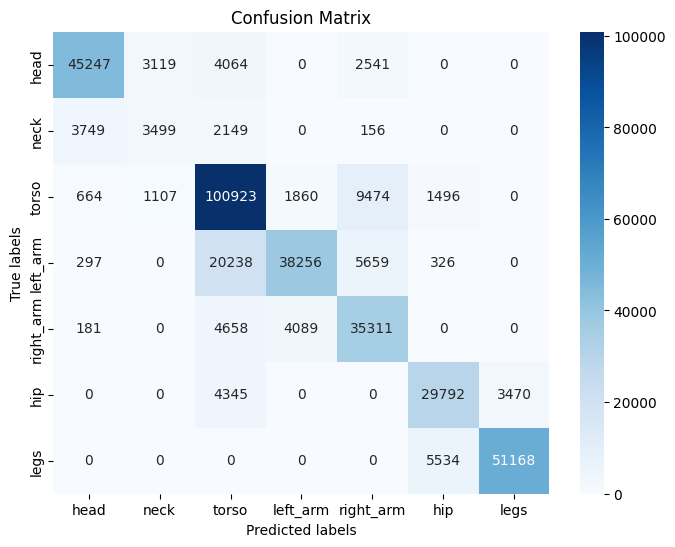

In [40]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(np.concatenate(all_true_labels), np.concatenate(all_predicted_labels))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

## Visualizing Predictions and Ground Truth

In [38]:
# generates colored output for either original mesh or predicted mesh
import numpy as np
from plyfile import PlyData, PlyElement
def generate_colored_output(mesh_path, predicted_labels_path = None):
    sample_name = mesh_path.split("/")[-1].split(".")[0]

    # Load the original mesh PLY file
    ply_data = PlyData.read(mesh_path)

    # Extract vertices and original labels
    vertices = np.vstack([
        ply_data['vertex']['x'],
        ply_data['vertex']['y'],
        ply_data['vertex']['z']
    ]).T  # Shape: (N, 3)

    if predicted_labels_path is not None:
        # predicted_nameofthesameple_colored.ply
        vertex_labels = np.loadtxt(predicted_labels_path, dtype=int)
        output_name = f"predicted_{sample_name}_colored.ply"
        output_dir = "results/predicted colored"
        output_path = os.path.join(output_dir, output_name)
    else:
        # nameofthesample_colored.ply
        vertex_labels = np.array(ply_data['vertex']['label'])  # Shape: (N,)
        output_name = f"{sample_name}_colored.ply"
        output_dir = "results/original colored"
        output_path = os.path.join(output_dir, output_name)


    # Define class colors (RGB format, range 0-255)
    class_colors = {
        1: (255, 0, 0),    # Red
        2: (0, 255, 0),    # Green
        3: (0, 0, 255),    # Blue
        4: (255, 255, 0),  # Yellow
        5: (255, 165, 0),  # Orange
        6: (128, 0, 128),  # Purple
        7: (0, 255, 255),  # Cyan
    }

    # Assign colors based on predicted labels
    colors = np.array([class_colors[label] for label in vertex_labels], dtype=np.uint8)

    # Create a new structured array for the vertex data
    vertex_data = np.empty(len(vertices), dtype=[
        ('x', 'f4'), ('y', 'f4'), ('z', 'f4'),  # Vertex positions
        ('red', 'u1'), ('green', 'u1'), ('blue', 'u1'),  # Vertex colors
        ('label', 'i4')  # Predicted labels
    ])

    # Fill vertex data with positions, colors, and predicted labels
    vertex_data['x'] = vertices[:, 0]
    vertex_data['y'] = vertices[:, 1]
    vertex_data['z'] = vertices[:, 2]
    vertex_data['red'] = colors[:, 0]
    vertex_data['green'] = colors[:, 1]
    vertex_data['blue'] = colors[:, 2]
    vertex_data['label'] = vertex_labels

    # Extract faces from the original mesh (if it's a mesh)
    if 'face' in ply_data:
        faces = ply_data['face']['vertex_indices']
        face_data = np.array([(tuple(face),) for face in faces], dtype=[('vertex_indices', 'i4', (3,))])
    else:
        face_data = None  # No faces (point cloud)

    # Save the updated mesh with new colors and labels
    new_ply_vertices = PlyElement.describe(vertex_data, 'vertex')
    if face_data is not None:
        new_ply_faces = PlyElement.describe(face_data, 'face')
        PlyData([new_ply_vertices, new_ply_faces]).write(output_path)
    else:
        PlyData([new_ply_vertices]).write(output_path)

    print(f"Updated mesh saved as '{output_name}' in the '{output_dir}' directory")

In [39]:
# generate colored output for either original mesh or predicted mesh
import os

mesh_dir = "data/val"
predicted_labels_dir = "results/predicted labels"
for file in os.listdir(mesh_dir):
    if file.endswith(".ply"):
        file_path = os.path.join(mesh_dir, file)
        predicted_labels_file = os.path.join(predicted_labels_dir, f"{os.path.splitext(file)[0]}_labels.txt")
        generate_colored_output(file_path, predicted_labels_file)
        generate_colored_output(file_path)


Updated mesh saved as 'predicted_raw_60_colored.ply' in the 'results/predicted colored' directory
Updated mesh saved as 'raw_60_colored.ply' in the 'results/original colored' directory
Updated mesh saved as 'predicted_raw_59_colored.ply' in the 'results/predicted colored' directory
Updated mesh saved as 'raw_59_colored.ply' in the 'results/original colored' directory
Updated mesh saved as 'predicted_raw_55_colored.ply' in the 'results/predicted colored' directory
Updated mesh saved as 'raw_55_colored.ply' in the 'results/original colored' directory
Updated mesh saved as 'predicted_raw_57_colored.ply' in the 'results/predicted colored' directory
Updated mesh saved as 'raw_57_colored.ply' in the 'results/original colored' directory
Updated mesh saved as 'predicted_raw_50_colored.ply' in the 'results/predicted colored' directory
Updated mesh saved as 'raw_50_colored.ply' in the 'results/original colored' directory
Updated mesh saved as 'predicted_raw_51_colored.ply' in the 'results/predic